In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import datetime
import os

from scipy import interpolate
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

(4, 420, 718)
(420,)
(420,)


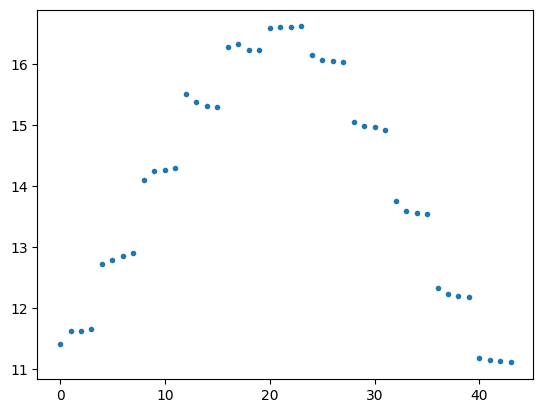

In [4]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"data/{transit.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array
    
def select_values(arr):
    result = [arr[i] for i in range(len(arr)) if (i % 4 == 2 or i % 4 == 3)]
    return result

def average_of_pairs(arr):
    # Ensure the array has an even number of elements
    if len(arr) % 2 != 0:
        raise ValueError("The array must have an even number of elements.")

    averages = []
    for i in range(0, len(arr), 2):
        avg = (arr[i] + arr[i+1]) / 2
        averages.append(avg)
    return averages

transit = Transit('19th July 2024', 0, 20.683044319285145, 0, 'W', datetime.datetime(2024, 7, 19, 12, 15, 34))
time, power = transit.get_data()

print(power.shape)
print(time.shape)

power_total = np.average(power[2], axis=1)
trimmed_power_total = power_total[173:217]
plt.plot(trimmed_power_total, ".")

elv_pwr_total = average_of_pairs(select_values(trimmed_power_total))
elv_ang = np.array([42.5, 45.4, 48.5, 50.8, 54.4, 57.3, 60.8, 63.4, 66.5, 69.6, 72.4])

print((power[2][:,0]).shape)

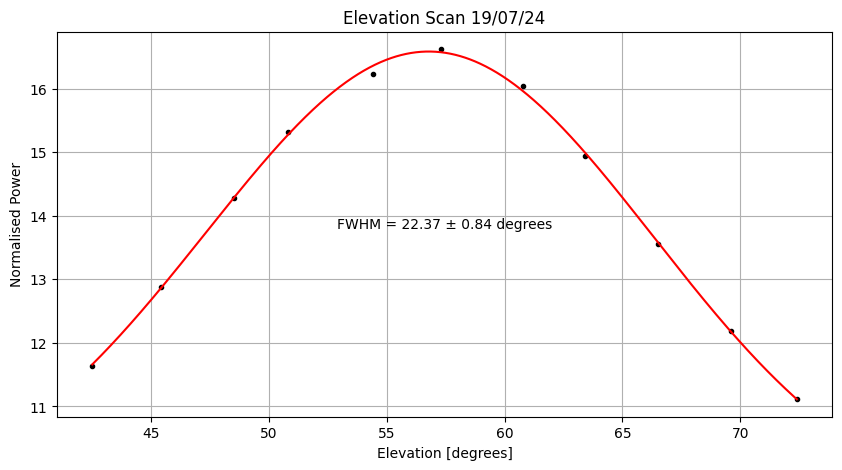

In [5]:
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), x[np.argmax(y)], 23, 0, 0])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

popt, pcov = gaussian_with_baseline_fitting(elv_ang, elv_pwr_total)

fwhm = popt[2]
fwhm_error = np.sqrt(np.diag(pcov)[2])

plt.figure(figsize=(10, 5))
plt.plot(elv_ang, elv_pwr_total, "k.")
plt.plot(np.linspace(np.min(elv_ang), np.max(elv_ang), 1000), gaussian_with_baseline(np.linspace(np.min(elv_ang), np.max(elv_ang), 1000), *popt), "r")
plt.xlabel('Elevation [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Elevation Scan 19/07/24")
plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()


22.418029583239438


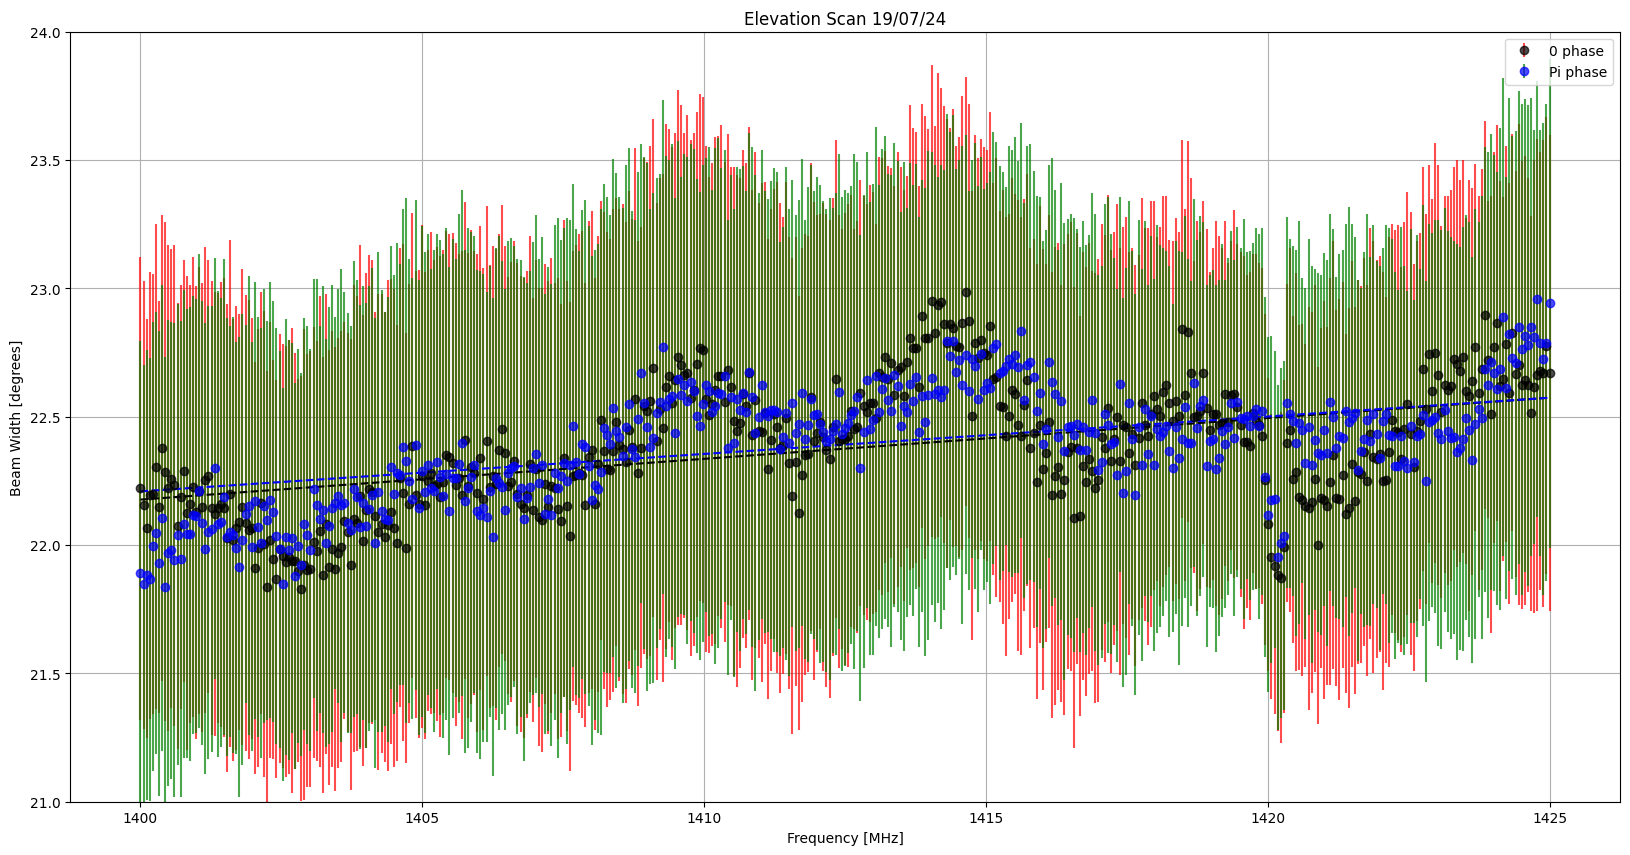

In [49]:
fwhm_freq = np.empty((457,2))
fwhm_freq_error = np.empty((457,2))
freq = np.linspace(1400, 1425, 457)


for i in range(112, 569):
    chnl_pwr = power[2][:,i]
    trimmed_pwr = chnl_pwr[173:217]
    elv_pwr = average_of_pairs(select_values(trimmed_pwr))
    popt, pcov = gaussian_with_baseline_fitting(elv_ang, elv_pwr)
    fwhm_freq[i-112][0] = popt[2]
    fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

for i in range(112, 569):
    chnl_pwr = power[3][:,i]
    trimmed_pwr = chnl_pwr[173:217]
    elv_pwr = average_of_pairs(select_values(trimmed_pwr))
    popt, pcov = gaussian_with_baseline_fitting(elv_ang, elv_pwr)
    fwhm_freq[i-112][1] = popt[2]
    fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq[43:647])
print(fwhm_average)

line_fit_0, line_errors_0 = line_fitting(freq[43:647], fwhm_freq[43:647][:,0], fwhm_freq_error[43:647][:,0])
line_fit_1, line_errors_1 = line_fitting(freq[43:647], fwhm_freq[43:647][:,1], fwhm_freq_error[43:647][:,1])

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Elevation Scan 19/07/24")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(21,24)
plt.legend()
plt.show()

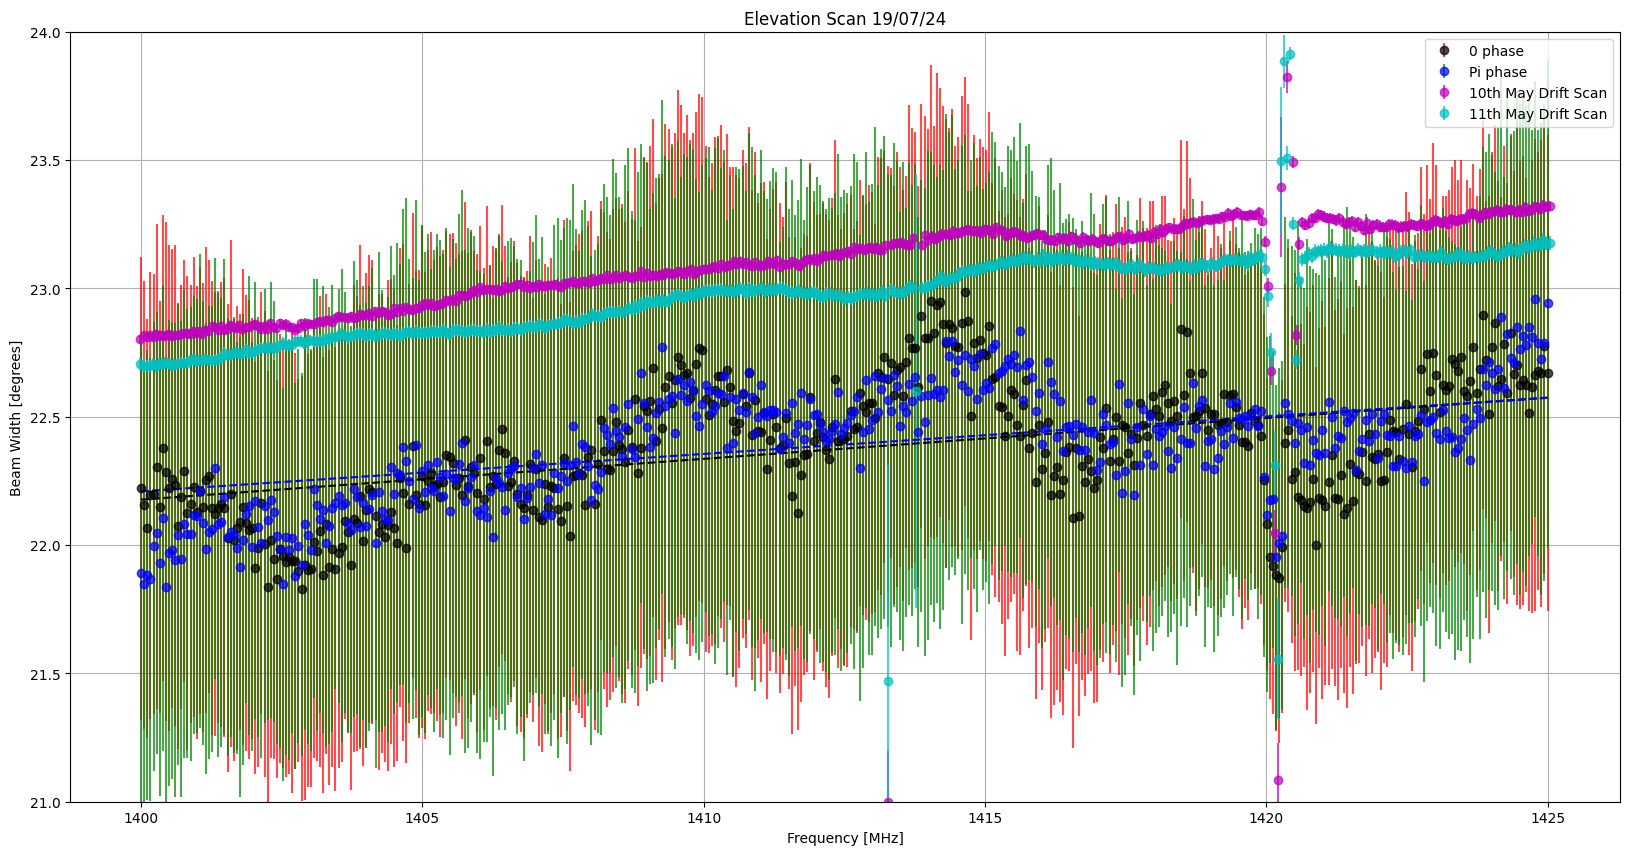

In [54]:
may10 = np.genfromtxt('data/beam_width_10th May 2024.txt')
may11 = np.genfromtxt('data/beam_width_11th May 2024.txt')

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.errorbar(may10[:,0], may10[:,1], may10[:,2], fmt="mo", alpha=0.7, label = '10th May Drift Scan')
plt.errorbar(may11[:,0], may11[:,1], may11[:,2], fmt="co", alpha=0.7, label = '11th May Drift Scan')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Elevation Scan 19/07/24")
plt.ylim(21,24)
plt.legend()
plt.show()